### Airline AI - brining it all together

In [2]:
import os, json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import sqlite3

In [3]:
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

OpenAI API Key exists and begins sk-proj-


In [4]:
# Connect to OpenAI client library
# A thin wrapper around calls to HTTP endpoints

openai = OpenAI()

MODEL = "gpt-4.1-mini"

In [5]:
system_message = """
You are a helpful assistant, for an airline called FlightAI.
Give short and courteous responses no more than one sentence long.
Always be accurate, if you don't know the answer, just say you don't know.
"""

In [6]:
DB = "prices.db"
with sqlite3.connect(DB) as conn:
    cursor = conn.cursor()
    cursor.execute('CREATE TABLE IF NOT EXISTS prices (city TEXT PRIMARY KEY, price REAL)')
    conn.commit()

In [7]:
def get_ticket_price(city):
    print(f"DATABASE TOOL CALLED: Getting price for {city}", flush=True)
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT price FROM prices WHERE city = ?', (city.lower(),))
        result = cursor.fetchone()
        return f"Ticket price to {city} is ${result[0]}" if result else "No price data available for this city"
    
def set_ticket_price(city, price):
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('INSERT INTO prices (city, price) VALUES (?, ?) ON CONFLICT(city) DO UPDATE SET price = ?', (city.lower(), price, price))
        conn.commit()

In [8]:
# There's a particular dictionary structure that's required to describe our function:
# There's a particular dictionary structure that's required to describe our function:

get_price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

set_price_function = {
    "name": "set_ticket_price",
    "description": "Set the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
            "price": {
                "type": "number",
                "description": "The price of a return ticket to the destination city",
            },
        },
        "required": ["destination_city", "price"],
        "additionalProperties": False
    }
}

tools = [
    {
        "type": "function",
        "function": get_price_function
    },
    {
        "type": "function",
        "function": set_price_function
    }
]

tools

[{'type': 'function',
  'function': {'name': 'get_ticket_price',
   'description': 'Get the price of a return ticket to the destination city.',
   'parameters': {'type': 'object',
    'properties': {'destination_city': {'type': 'string',
      'description': 'The city that the customer wants to travel to'}},
    'required': ['destination_city'],
    'additionalProperties': False}}},
 {'type': 'function',
  'function': {'name': 'set_ticket_price',
   'description': 'Set the price of a return ticket to the destination city.',
   'parameters': {'type': 'object',
    'properties': {'destination_city': {'type': 'string',
      'description': 'The city that the customer wants to travel to'},
     'price': {'type': 'number',
      'description': 'The price of a return ticket to the destination city'}},
    'required': ['destination_city', 'price'],
    'additionalProperties': False}}}]

In [9]:
def handle_tool_calls(message):
    response = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            price_details = get_ticket_price(city)
            response.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
        elif tool_call.function.name == "set_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            price = arguments.get('price')
            set_ticket_price(city, price)
            response.append({
                "role": "tool",
                "content": f"Ticket price for {city} set to ${price}",
                "tool_call_id": tool_call.id
            })
    return response

In [10]:
def chat(message, history):
    updated_history = [{'role': message['role'], 'content': message['content']} for message in history]

    messages = [{'role': 'system', 'content': system_message}]
    messages.extend(updated_history)
    messages.append({'role': 'user', 'content': message})

    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    # if the finish reason is tool calls then, we need to call the tool
    while response.choices[0].finish_reason=="tool_calls":
        message_asst = response.choices[0].message
        tool_response = handle_tool_calls(message_asst)
        messages.append(message_asst)
        messages.extend(tool_response)
 
        for msg in messages:
            print(msg)

        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
        print(f"Final response: {response.choices[0].message}")  # 
    
    return response.choices[0].message.content

In [11]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


#### A bit more about what Gradio actually does:
- Gradio constructs a frontend Svelte app based on our Python description of the UI
- Gradio starts a server built upon the Starlette web framework listening on a free port that serves this React app
- Gradio creates backend routes for our callbacks, like chat(), which calls our functions

And of course when Gradio generates the frontend app, it ensures that the the Submit button calls the right backend route.

That's it!

It's simple, and it has a result that feels magical.

### Let's go multi-modal!!
We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [19]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [20]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

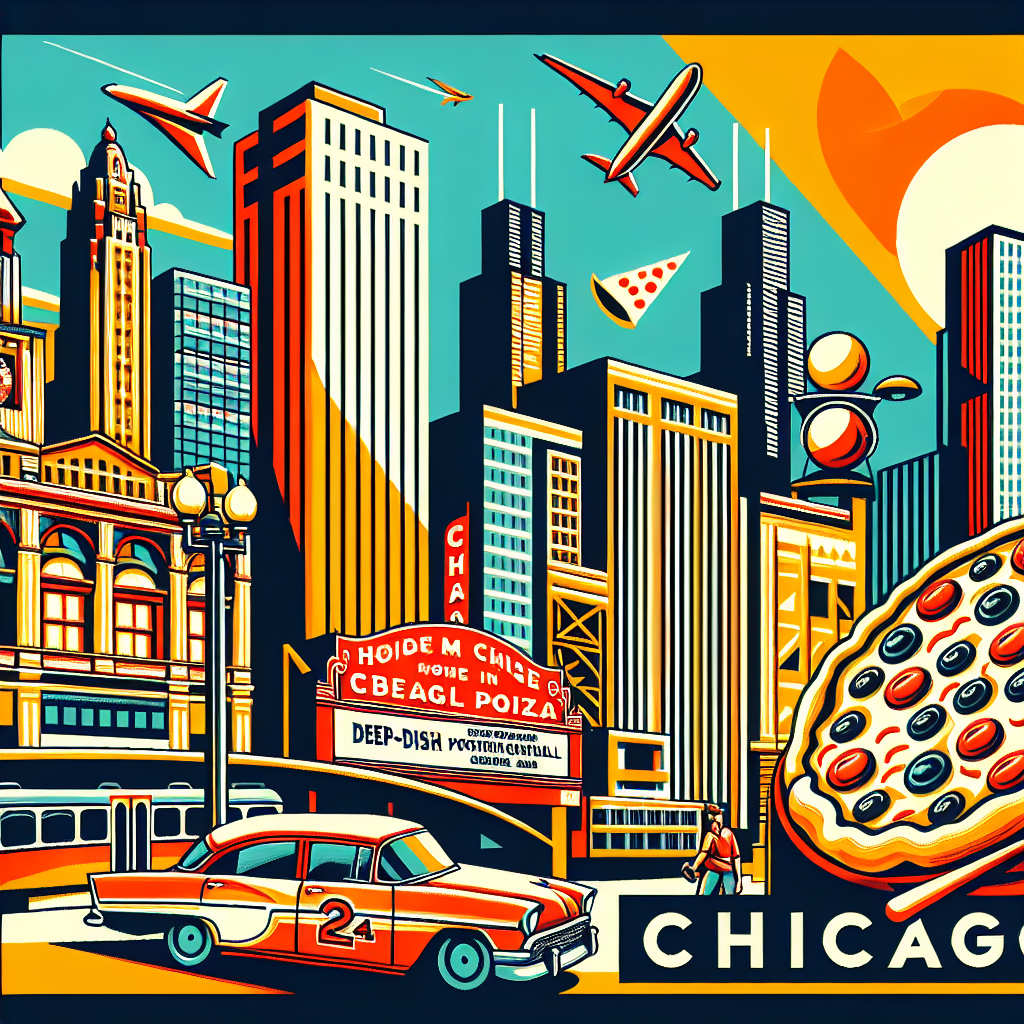

In [14]:
image = artist("Chicago")
display(image)

In [21]:
def talker(message):
    response = openai.audio.speech.create(
      model="gpt-4o-mini-tts",
      voice="onyx",    # Also, try replacing onyx with alloy or coral
      input=message
    )
    return response.content

Let's bring this home:
- A multi-modal AI assistant with image and audio generation
- Tool callling with database lookup
- A step towards an Agentic workflow

In [22]:
def handle_tool_calls_with_city(message):
    response = []
    cities = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price_details = get_ticket_price(city)
            response.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
        elif tool_call.function.name == "set_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            price = arguments.get('price')
            cities.append(city)
            set_ticket_price(city, price)
            response.append({
                "role": "tool",
                "content": f"Ticket price for {city} set to ${price}",
                "tool_call_id": tool_call.id
            })
    return response, cities

In [25]:
def chat(history):
    updated_history = [{'role': message['role'], 'content': message['content']} for message in history]

    messages = [{'role': 'system', 'content': system_message}]
    messages.extend(updated_history)
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    cities = []
    image = None

    # if the finish reason is tool calls then, we need to call the tool
    while response.choices[0].finish_reason=="tool_calls":
        message_asst = response.choices[0].message
        tool_response, cities = handle_tool_calls_with_city(message_asst)
        messages.append(message_asst)
        messages.extend(tool_response)

        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    reply = response.choices[0].message.content
    updated_history.append({'role': response.choices[0].message.role, 'content': reply})

    if cities:
        image = artist(cities[0])

    voice = talker(reply)
    return updated_history, voice, image



#### The 3 types of Gradio UI
`gr.Interface` is for standard, simple UIs

`gr.ChatInterface` is for standard ChatBot UIs

`gr.Blocks` is for custom UIs where you control the components and the callbacks

In [ ]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role": "user", "content": message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )

ui.launch(inbrowser=True, auth=("srini", "bananas"))

* Running on local URL:  http://127.0.0.1:7871
* To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for new york
DATABASE TOOL CALLED: Getting price for Paris
